In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import functions_data_processing as fsd
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from itertools import combinations
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [2]:
gt = ["cat", "cat", "cat", "cat", "dog", "dog", "dog", "cat", "cat", "dog"]*5
gt = np.array([1 if x == 'cat' else 0 for x in gt])

In [3]:

# For this example, we will model the stages of a conversation,
# where each sentence is "generated" with an underlying topic, "cat" or "dog"
states = ["cat", "dog"]
id2topic = dict(zip(range(len(states)), states))
# we are more likely to talk about cats first
start_probs = np.array([0.6, 0.4])

# For each topic, the probability of saying certain words can be modeled by
# a distribution over vocabulary associated with the categories

vocabulary = ["tail", "fetch", "mouse", "food"]
# if the topic is "cat", we are more likely to talk about "mouse"
# if the topic is "dog", we are more likely to talk about "fetch"
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Also assume it's more likely to stay in a state than transition to the other
trans_mat = np.array([[0.8, 0.2], [0.2, 0.8]])


# Pretend that every sentence we speak only has a total of 5 words,
# i.e. we independently utter a word from the vocabulary 5 times per sentence
# we observe the following bag of words (BoW) for 8 sentences:
observations = [["tail", "mouse", "mouse", "food", "mouse"],
        ["food", "mouse", "mouse", "food", "mouse"],
        ["tail", "mouse", "mouse", "tail", "mouse"],
        ["food", "mouse", "food", "food", "tail"],
        ["tail", "fetch", "mouse", "food", "tail"],
        ["tail", "fetch", "fetch", "food", "fetch"],
        ["fetch", "fetch", "fetch", "food", "tail"],
        ["food", "mouse", "food", "food", "tail"],
        ["tail", "mouse", "mouse", "tail", "mouse"],
        ["fetch", "fetch", "fetch", "fetch", "fetch"]]

# Convert "sentences" to numbers:
vocab2id = dict(zip(vocabulary, range(len(vocabulary))))
def sentence2counts(sentence):
    ans = []
    for word, idx in vocab2id.items():
        count = sentence.count(word)
        ans.append(count)
    return ans

X = []
for sentence in observations:
    row = sentence2counts(sentence)
    X.append(row)

data = np.array(X, dtype=int)

# pretend this is repeated, so we have more data to learn from:
lengths = [len(X)]*5
sequences = np.tile(data, (5,1))


# Set up model:
model = hmm.MultinomialHMM(n_components=len(states),
        n_trials=len(observations[0]),
        n_iter=50,
        init_params='')

model.n_features = len(vocabulary)
model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs


model.fit(sequences, lengths)
logprob, received = model.decode(sequences)

print("Topics discussed:")
print([id2topic[x] for x in received])

print("Learned emission probs:")
print(model.emissionprob_)

print("Learned transition matrix:")
print(model.transmat_)






MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Topics discussed:
['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog']
Learned emission probs:
[[2.57129200e-01 2.86190571e-02 4.28541642e-01 2.85710101e-01]
 [1.33352852e-01 7.33292496e-01 2.67548571e-05 1.33327897e-01]]
Learned transition matrix:
[[0.71429762 0.28570238]
 [0.50007593 0.49992407]]


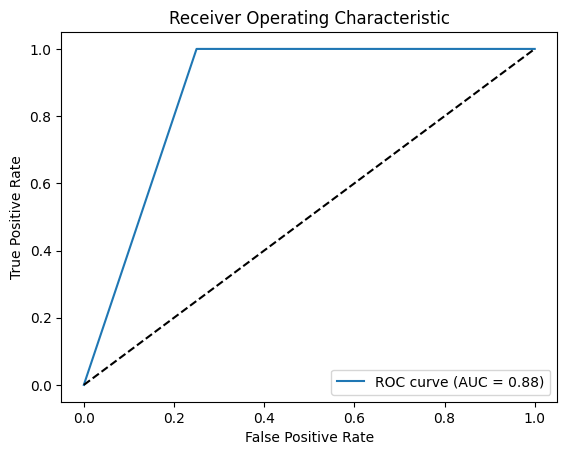

Confusion matrix
[[15  5]
 [ 0 30]]


In [4]:
y_scores = [id2topic[x] for x in received]
y_scores = np.array([1 if x == 'cat' else 0 for x in y_scores])


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(gt, y_scores)

# Calculate AUC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("Confusion matrix")
print(confusion_matrix(gt, y_scores))

In [5]:
# Try to reset and refit:
new_model = hmm.MultinomialHMM(n_components=len(states),
        n_trials=len(observations[0]),
        n_iter=50, init_params='ste')

new_model.fit(sequences, lengths)
logprob, received = new_model.decode(sequences)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [6]:
print("\nNew Model")
print("Topics discussed:")
print([id2topic[x] for x in received])

print("Learned emission probs:")
print(new_model.emissionprob_)

print("Learned transition matrix:")
print(new_model.transmat_)


New Model
Topics discussed:
['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog']
Learned emission probs:
[[2.57131701e-01 2.86221495e-02 4.28537450e-01 2.85708700e-01]
 [1.33341747e-01 7.33315275e-01 1.82979355e-05 1.33324680e-01]]
Learned transition matrix:
[[0.71430295 0.28569705]
 [0.50010745 0.49989255]]


In [7]:
print(len(sequences))

50


Split: 0
[[1 6]
 [8 0]]
Split: 1
[[2 6]
 [7 0]]
Split: 2
[[1 5]
 [9 0]]
Split: 3
[[0 6]
 [9 0]]
Split: 4
[[2 4]
 [9 0]]


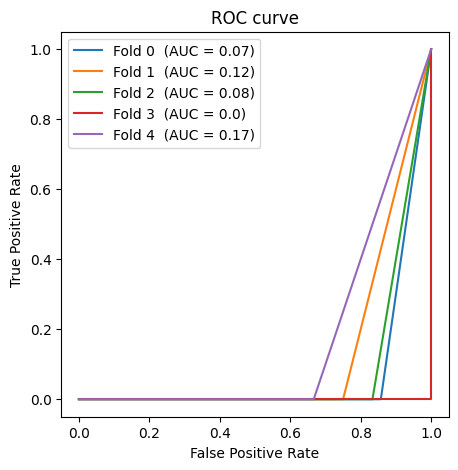

In [8]:

ss = ShuffleSplit(n_splits=5, test_size=0.3)

fig, ax = plt.subplots(figsize=(5, 5))


y = gt
x = sequences
for split_number, (train_index, test_index) in enumerate(ss.split(x, y)):

    print("Split:", split_number)
    

    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]


    model.fit(X_train)
    logprob, state_ests = model.decode(X_test)

    y_pred_proba = state_ests
    
    print(confusion_matrix(y[test_index], y_pred_proba))
    

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()


